# Kernel Tuner Backends Test

This notebook is intended to examine performance differences in the Kernel Tuner backends.

In [1]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# arguments
kernel = "gemm_opencl_cuda"
expected_keys = ['time', 'GFLOP/s', 'compile_time', 'benchmark_time', 'framework_time', 'REPEAT']
observer_keys = ['mem_freq', 'core_freq', 'temperature', 'num_regs']
backend_displaynames = {
    'CUDA': 'PyCUDA',
    'CUPY': 'CuPy',
    'NVCUDA': 'CUDA-Python',
}
backends = sorted(list(backend_displaynames.values()))
cuda_versions = ['11.2', '12.3']
plot_height = 6
plot_aspect = 2.0

In [3]:
def get_dataframe(observers=False, old_data=False) -> pd.DataFrame:

    # get the path to the cachefiles directory
    if old_data:
        folder_clock = "variable_clock_size-4096"
        folder_observers = "observers" if observers else "no_observers"
        cachefiles_path = Path("kernels/outputdata").resolve() / folder_clock / folder_observers
    else:
        cachefiles_path = Path("kernels/outputdata").resolve() / kernel
    assert cachefiles_path.exists()

    # get all relevant cachefiles
    cachefiles : list[Path] = []
    for file in cachefiles_path.iterdir():
        if file.is_file() and file.name.startswith(kernel) and "_noisetest" in file.name and "_cache" in file.name and file.suffix == '.json':
            cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    for filepath in cachefiles:
        cachefile = json.load(filepath.open())
        device_name = cachefile['device_name']
        backend = backend_displaynames[re.search(r"_backend-([a-zA-Z]+)_", filepath.name).group(1).strip()]
        CUDA_version = re.search(r"_CUDA-(.*)_", filepath.name).group(1).strip()
        CUDA_backend= f"c:{CUDA_version} | b:{backend}"
        backend_CUDA = f"b:{backend} | c:{CUDA_version}"
        # for each of the configurations, create a dictionary with the expected items
        for value in cachefile['cache'].values():
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['backend'] = backend
            cache['backend | CUDA version'] = backend_CUDA
            cache['CUDA version | backend'] = CUDA_backend
            cache['CUDA version'] = CUDA_version
            for key in expected_keys:
                cache[key] = value[key]
            cache['total_time'] = value['compile_time'] + value['benchmark_time'] + value['framework_time']
            if observers:
                for key in observer_keys:
                    if key in value:
                        cache[key] = value[key]
            cache_dicts.append(cache)

    # create a dataframe out of the dictionaries
    return pd.DataFrame(cache_dicts)

In [4]:
df = get_dataframe(observers=False)

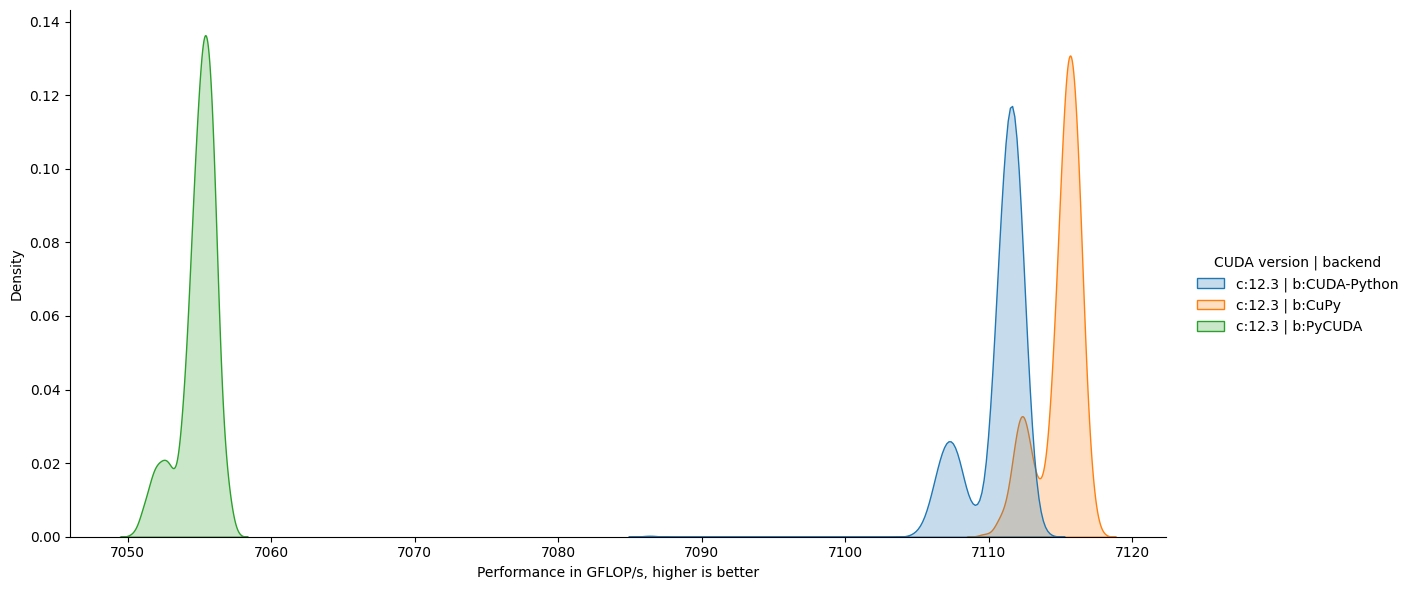

In [5]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Performance in GFLOP/s, higher is better")

The figure above shows a histogram for each combination of CUDA version and backend. The difference in performance between the CUDA 11.2 and 12.3 is quite visible. Whereas with PYCUDA CUDA 11.2 slightly outperforms 12.3, for CuPy the difference is noticeable. CUDA-Python performs very similarly to CuPy, even having the same distribution shape. In general, none of the backends demonstrate large variation in performance. 

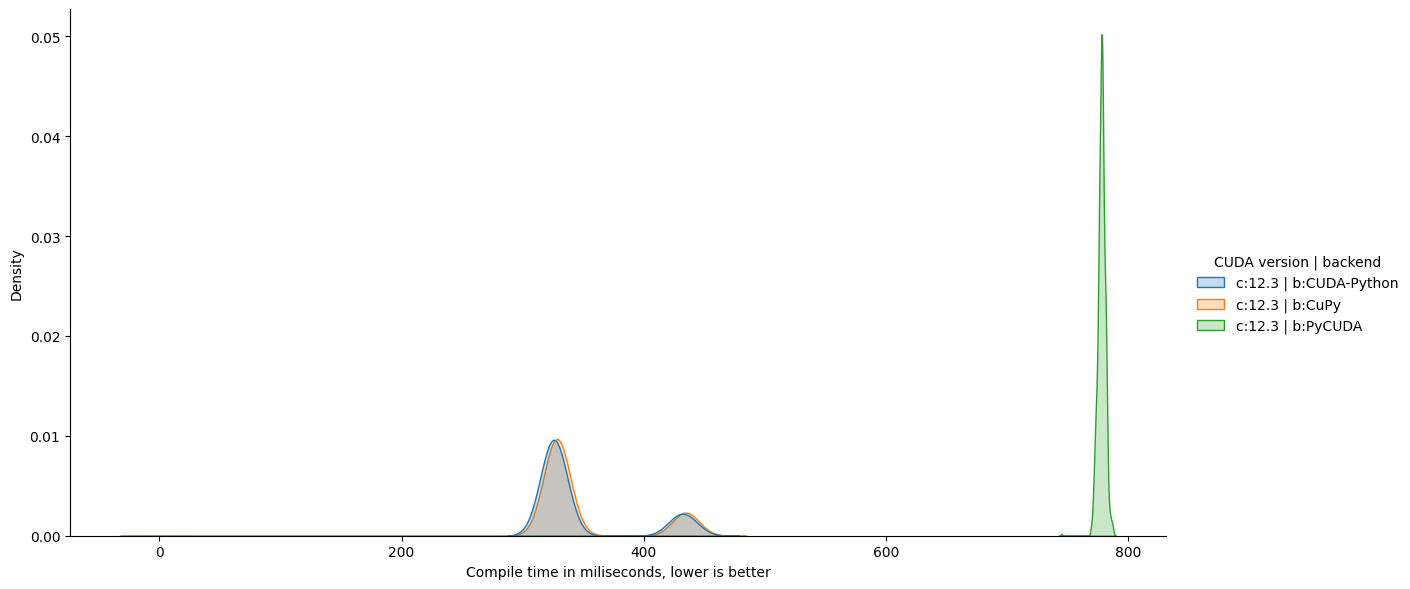

In [6]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='compile_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Compile time in miliseconds, lower is better")

Interestingly, the backends that provided the best performance in the previous plot (CuPy at 12.3 and CUDA-Python), also perform best in terms of compile time. The CuPy compile time on CUDA 12.3 is very similar to that of CUDA-Python as they both use NVRTC, whereas PyCUDA uses NVCC. 

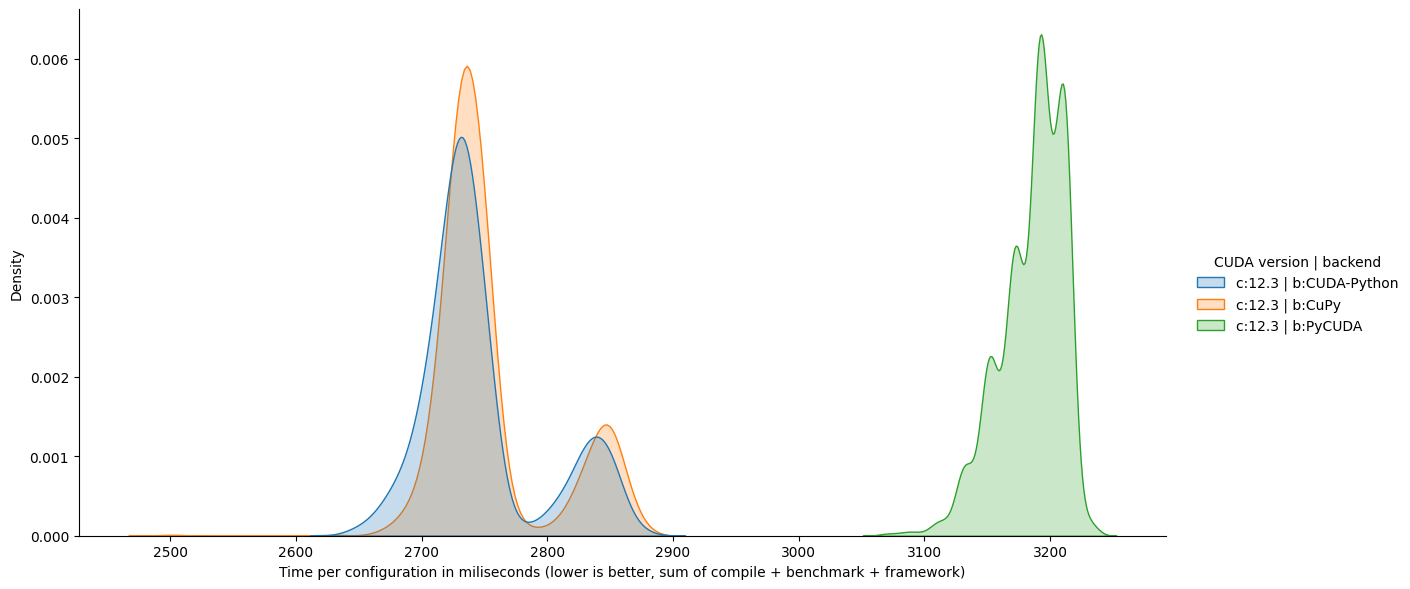

In [7]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='total_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Time per configuration in miliseconds (lower is better, sum of compile + benchmark + framework)")

Looking at the distribution of the total time per configuration, CuPy and CUDA-Python on CUDA 12.3 are the fastest overall, as expected given that they are fastest to compile and produce the best performing kernels. The large difference with CuPy on CUDA 11.2 and PyCUDA on CUDA 12.3 is quite important, as it implies that for a searchspace too large to explore exhaustively, ~18.5% more configurations can be explored in the same amount of time by simply choosing a different backend.

Text(0, 0.98, 'backend | CUDA version')

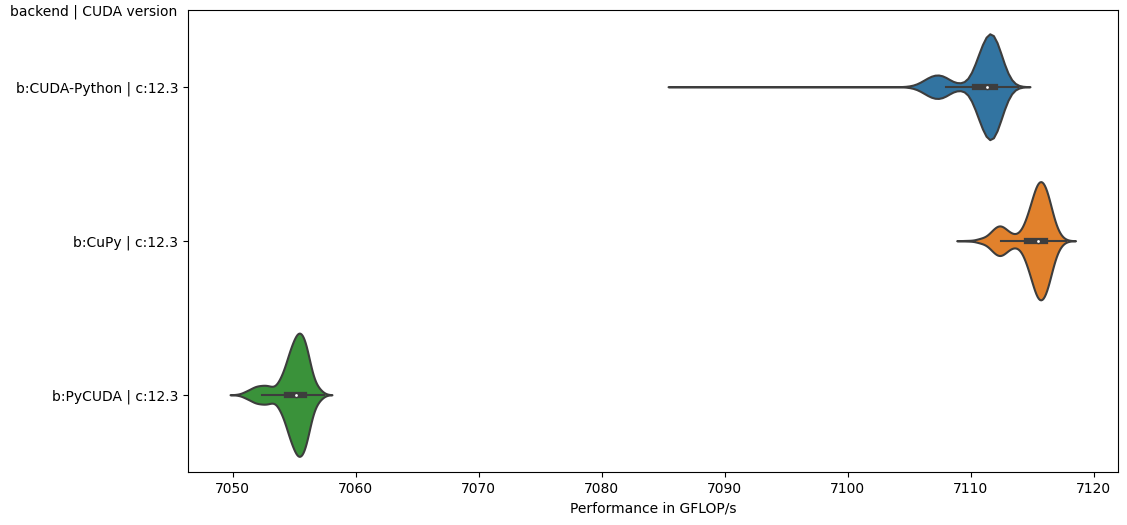

In [8]:
fig = plt.gcf()
fig.set_size_inches(plot_aspect*plot_height, plot_height)
g = sns.violinplot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', y='backend | CUDA version')
g.set_xlabel("Performance in GFLOP/s")
g.set_ylabel('backend | CUDA version', rotation=0, y=.98, horizontalalignment='left')

## Investigating with Observers

In [9]:
df = get_dataframe(observers=True)

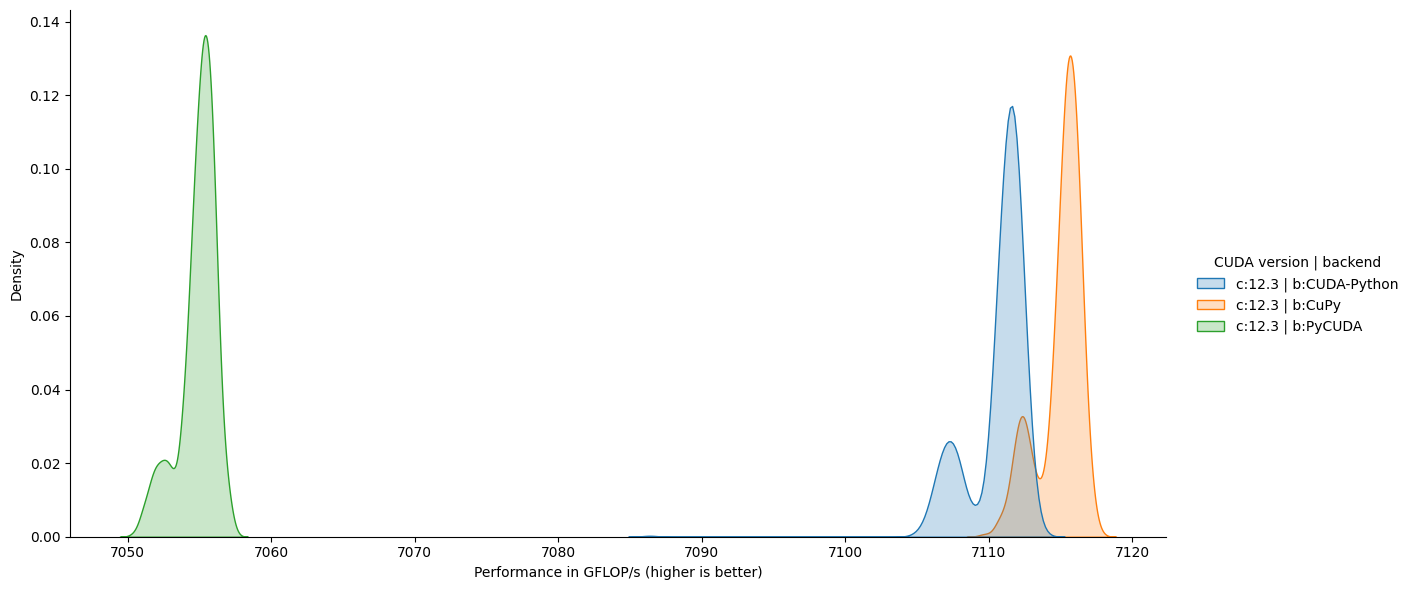

In [10]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Performance in GFLOP/s (higher is better)")

Sanity check: do we still see the same distributions with observers as we did without?

Text(0, 0.5, 'Average number of registers used')

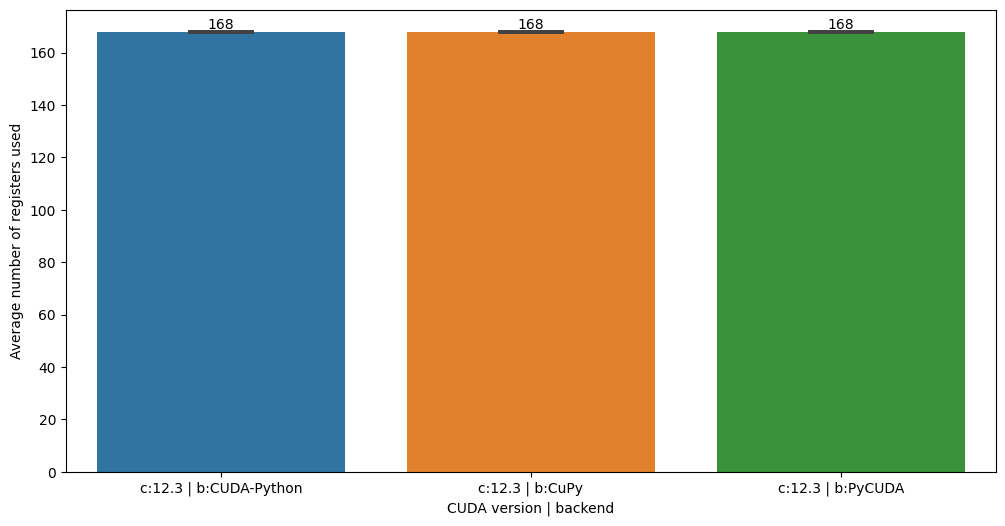

In [11]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height))
g = sns.barplot(data=df.sort_values(['CUDA version', 'backend']), x='CUDA version | backend', y="num_regs", estimator=np.mean, errorbar='sd', capsize=.2)
g.bar_label(g.containers[0])
g.set_ylabel("Average number of registers used")

Looking at the average number of registers, there is a small difference with PyCUDA using one additional register. 

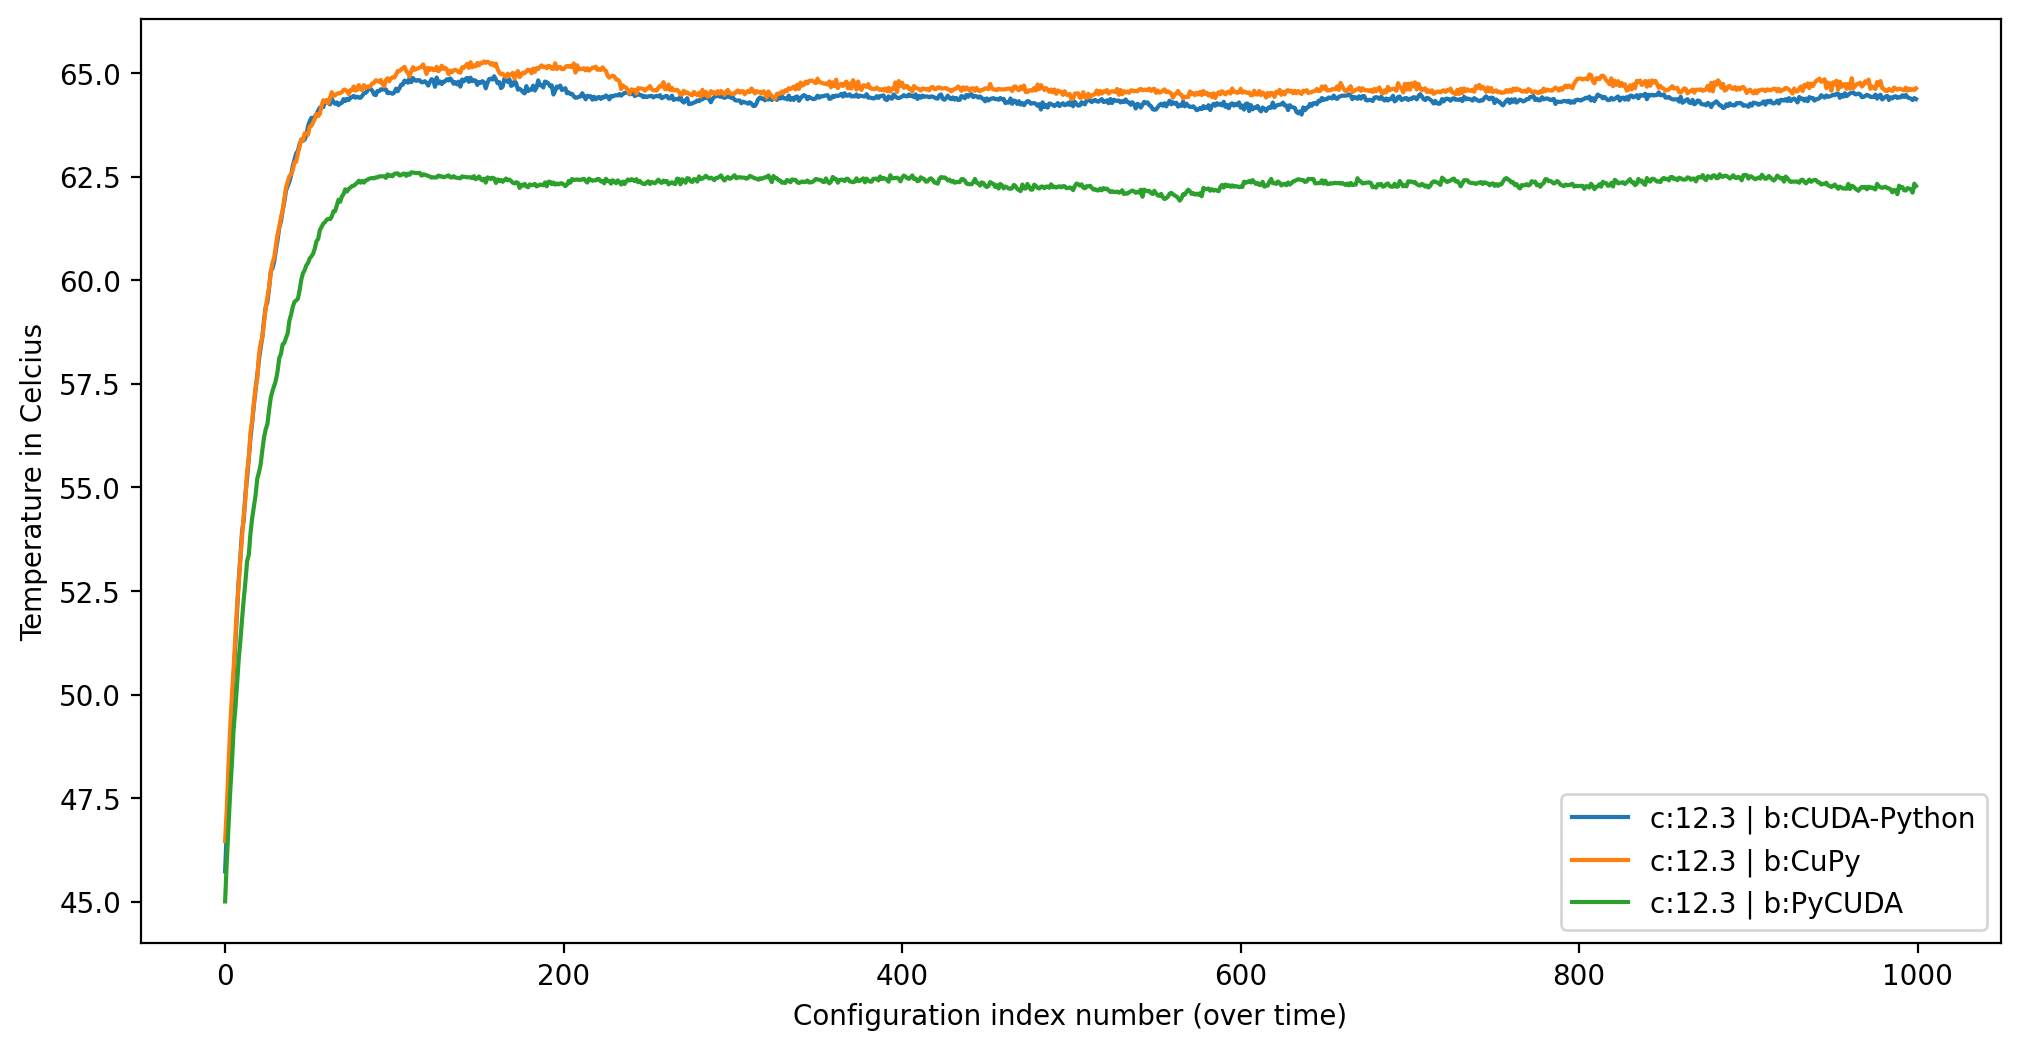

In [12]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=200)
for cuda_version in sorted(cuda_versions):
    for backend in sorted(backends):
        f_df = df.loc[(df['backend'] == backend) & (df['CUDA version'] == cuda_version)]
        if f_df.size > 0:
            sns.lineplot(data=f_df.sort_values(['temperature']), y='temperature', x='REPEAT', label=f_df['CUDA version | backend'].iloc[0])
plt.ylabel("Temperature in Celcius")
plt.xlabel("Configuration index number (over time)")
plt.legend()

If we look at the temperature of each backend, it is interesting to note that while the core and memory clock frequencies have been fixed, there are temperature differences between the backends. 